### Step 1: Import Libraries

In [12]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import numpy as np
import os, glob

from skimage.transform import resize
from skimage.io import imread

import seaborn as sns


### Step 2: Load and preprocess the fish dataset

In [2]:
data_dir = r"D:\VS projects\fish_classifier\Fish_Dataset"

X = []
y = []

for class_name in os.listdir(data_dir):
    class_folder = os.path.join(data_dir, class_name)

    # skip GT folders
    if not os.path.isdir(class_folder) or class_name.endswith("GT"):
        continue
    
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)

        try:
            img = imread(img_path)   # load image
            img = resize(img, (128,128), anti_aliasing=True) 
            X.append(img)            # append image as is
            y.append(class_name)     # append label
        except:
            print("Error loading:", img_path)



X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)   # (num_samples, H, W)
print("y shape:", y.shape)   # (num_samples,)

X shape: (9000, 128, 128, 3)
y shape: (9000,)


In [3]:
# Convert class names to numeric labels
classes = sorted(set(y))  # unique class names
class_to_idx = {c: i for i, c in enumerate(classes)}

# Apply mapping
y_num = np.array([class_to_idx[label] for label in y])

num_classes = len(np.unique(y))  

### Step 3: Build transfer model function

In [4]:
def build_transfer_model(base_model, num_classes):
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())  # Global pooling    
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(num_classes, activation='softmax'))  # Output layer
    return model



### Step 4: Cross-Validation: Best Fold Performance


In [5]:
fold_no = 1
val_accuracies = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_acc = -1
best_fold = None
best_model = None
best_history = None
best_x_val = None
best_y_val = None
best_y_pred_fold = None

for train_idx, val_idx in kf.split(X):
    print(f"\n===== Fold {fold_no} =====")

    # Split data
    x_train, x_val = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y_num[train_idx], y_num[val_idx]

    # Preprocess
    x_train = x_train.astype("float32")
    x_val   = x_val.astype("float32")

    y_train_fold = to_categorical(y_train_fold, num_classes)
    y_val_fold   = to_categorical(y_val_fold, num_classes)

    # Build a NEW model for each fold
    base_model_kf = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
    
    #Fine-tune last 20 layers
    base_model_kf.trainable = True
    for layer in base_model_kf.layers[:-20]:
        layer.trainable = False


    model_kf = build_transfer_model(base_model_kf, num_classes)
    model_kf.compile(optimizer= Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train
    history_kf = model_kf.fit(x_train, y_train_fold, validation_data=(x_val, y_val_fold), epochs=10, batch_size=64)

    # Evaluate
    loss, acc = model_kf.evaluate(x_val, y_val_fold, verbose=0)
    print(f"Fold {fold_no} Accuracy: {acc:.4f}")

    y_pred_fold = model_kf.predict(x_val)

    # Save the best fold
    if acc > best_acc:
        best_acc = acc
        best_fold = fold_no
        best_model = model_kf
        best_history = history_kf        
        best_y_val = y_val_fold       
        best_y_pred_fold = y_pred_fold

    fold_no += 1

print("\nBest Fold:", best_fold)
print("Best Fold Accuracy:", best_acc)


===== Fold 1 =====
Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.3344 - loss: 2.1018 - val_accuracy: 0.4289 - val_loss: 1.6010
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - accuracy: 0.6986 - loss: 0.9150 - val_accuracy: 0.6278 - val_loss: 1.0684
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.8396 - loss: 0.5242 - val_accuracy: 0.7267 - val_loss: 0.7786
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - accuracy: 0.9033 - loss: 0.3446 - val_accuracy: 0.8056 - val_loss: 0.5811
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 187ms/step - accuracy: 0.9382 - loss: 0.2390 - val_accuracy: 0.8522 - val_loss: 0.4398
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accuracy: 0.9564 - loss: 0.1840 - val_accuracy: 0.8906 - val_loss: 0.3376
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 185ms/step - accuracy: 0.9690 - loss: 0.1402 - val_accuracy: 0.9122 - val_loss: 0.2604
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - accura

### Step 5: Final Evaluation and Visualization

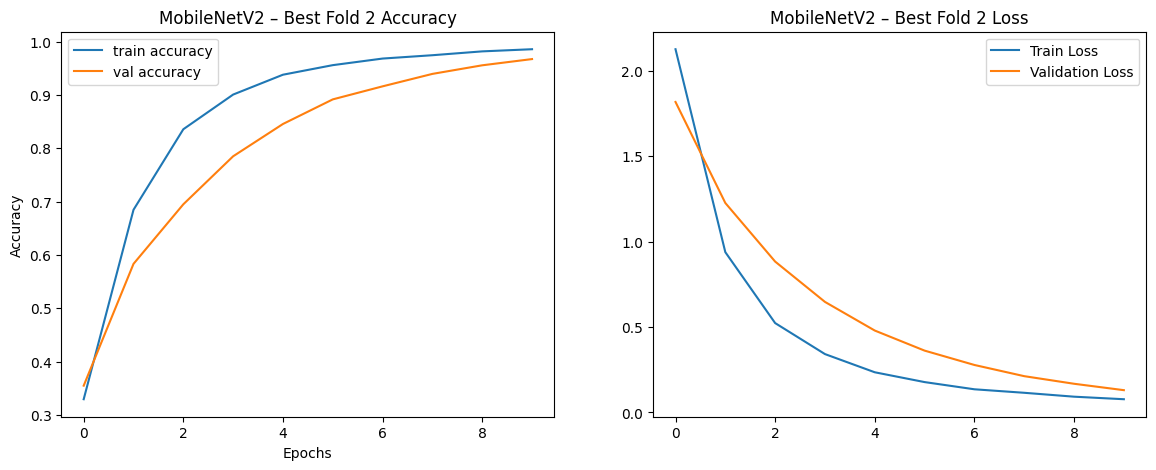


Classification Report for MobileNetV2 (Best Fold 2):
              precision    recall  f1-score   support

           0     0.9364    0.9866    0.9609       224
           1     0.9811    0.9498    0.9652       219
           2     0.9902    0.9531    0.9713       213
           3     1.0000    0.9695    0.9845       197
           4     0.9810    0.9904    0.9856       208
           5     0.9184    0.9574    0.9375       188
           6     1.0000    0.9375    0.9677       192
           7     0.9043    0.9884    0.9444       172
           8     1.0000    0.9733    0.9864       187

    accuracy                         0.9672      1800
   macro avg     0.9679    0.9673    0.9671      1800
weighted avg     0.9688    0.9672    0.9675      1800


Confusion Matrix for MobileNetV2 (Best Fold 2):


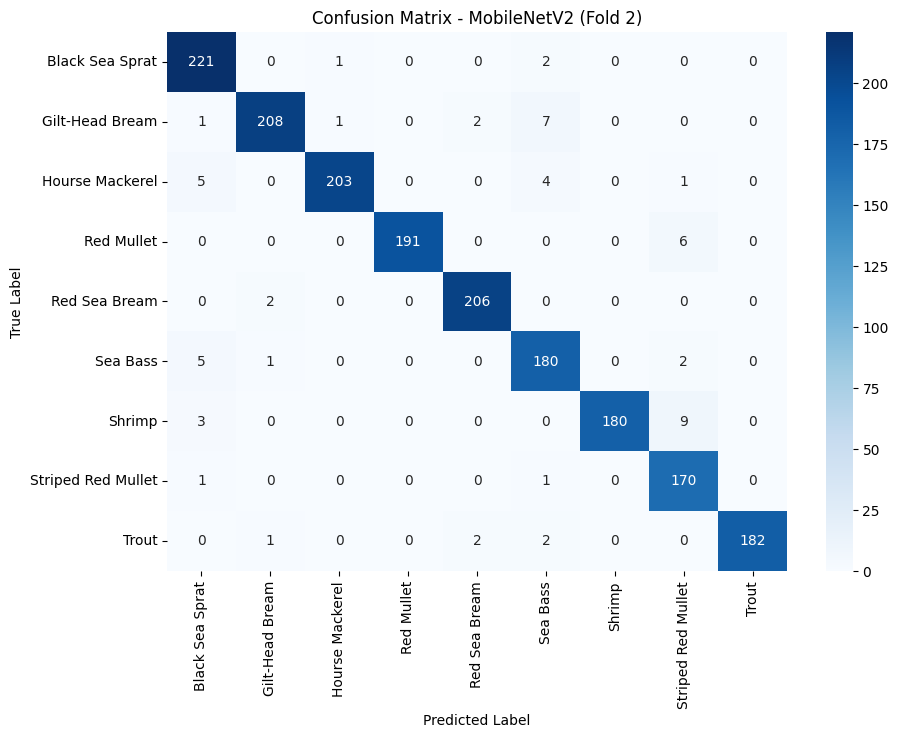

In [14]:
class_names = ['Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass', 'Shrimp', 'Striped Red Mullet', 'Trout']
# Plot accuracy curves
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'], label='train accuracy')
plt.plot(best_history.history['val_accuracy'], label='val accuracy')
plt.title(f'MobileNetV2 – Best Fold {best_fold} Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title(f'MobileNetV2 – Best Fold {best_fold} Loss')
plt.legend()
plt.show()

# Evaluate the model and generate confusion matrix
y_pred = np.argmax(best_y_pred_fold, axis=1)
y_true = np.argmax(best_y_val, axis=1)

print(f"\nClassification Report for MobileNetV2 (Best Fold {best_fold}):")
print(classification_report(y_true, y_pred, digits=4))

print(f"\nConfusion Matrix for MobileNetV2 (Best Fold {best_fold}):")

plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - MobileNetV2 (Fold {best_fold})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

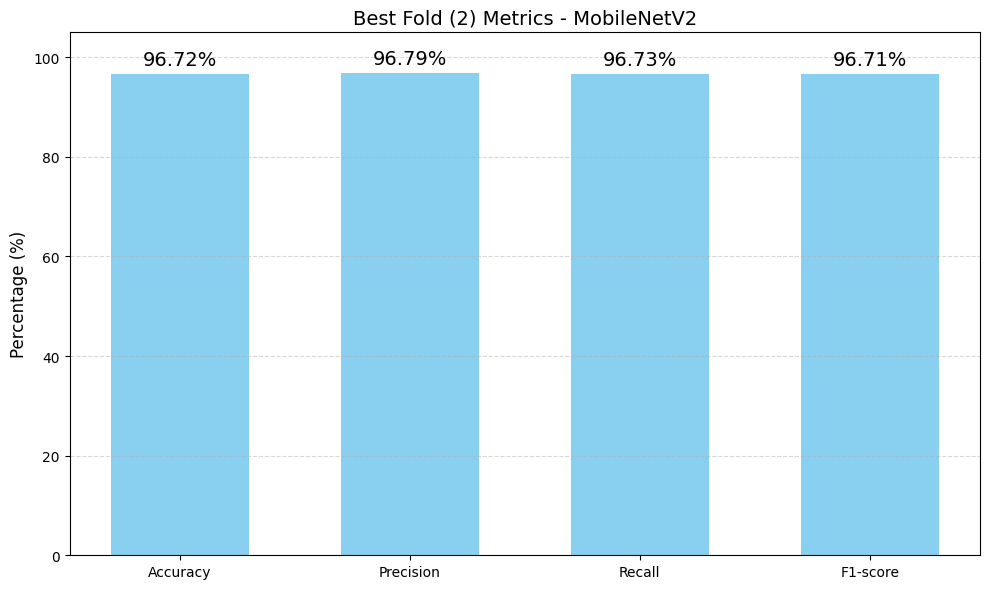

In [10]:
def plot_metrics_graph(metrics_values, title):
    # 1. Setup Data
    metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-score']
    
    # Check if input length matches expected metrics
    if len(metrics_values) != 4:
        print("Warning: Expected 4 metric values (Accuracy, Precision, Recall, F1).")

    # Convert values to percentages
    values_pct = [x * 100 for x in metrics_values]
    
    # 2. Create the Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars
    bars = ax.bar(metric_names, values_pct, color='#89CFF0', width=0.6, zorder=1)
    
    # 3. Add Value Labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{height:.2f}%',
                ha='center', va='bottom', fontsize=14, color='black')
    
    # 4. Styling
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Percentage (%)', fontsize=12)
    ax.set_ylim(0, 105) 
    ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)
    
    plt.tight_layout()
    plt.show()

mobilenet = [0.9672 ,0.9679  ,  0.9673  ,  0.9671]
plot_metrics_graph(mobilenet, 'Best Fold (2) Metrics - MobileNetV2') 



### Save the model

In [ ]:
best_model.save("MobileNetV2_fold01_model.h5")